In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pylab import rcParams
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import adfuller
from time import time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
rcParams['figure.figsize']= 20, 5
import warnings
warnings.filterwarnings('ignore','No frequency information was')

In [2]:
df=pd.read_csv('D:\\Data_sets\\time_series\\catfish.csv')
df

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239
...,...,...
319,2012-8-01,14442
320,2012-9-01,13422
321,2012-10-01,13795
322,2012-11-01,13352


In [3]:
df.rename(columns={'Date': 'date'}, inplace=True)

In [4]:
#convert date column to datetime type
df['date'] = pd.to_datetime(df.date)

In [5]:
df.set_index('date', inplace=True)

In [6]:
ts = df['Total']
ts.head(10)

date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
1986-06-01     8951
1986-07-01     9668
1986-08-01    10188
1986-09-01     9896
1986-10-01    10649
Name: Total, dtype: int64

In [7]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
ts = ts[start_date:end_date]

Text(0, 0.5, 'Sales')

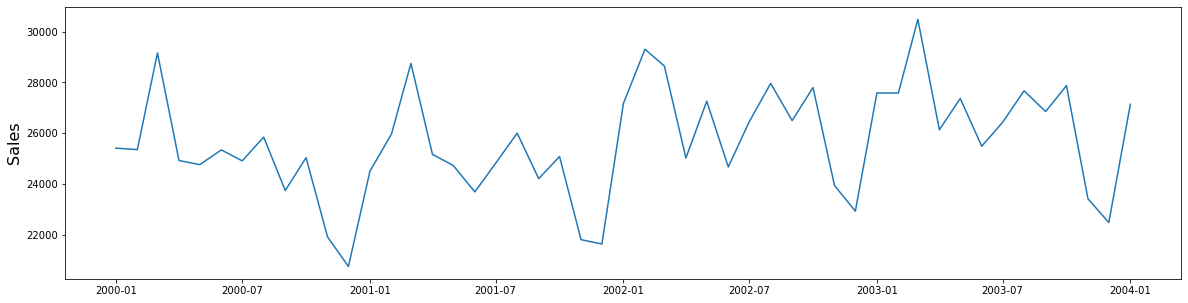

In [8]:
plt.plot(ts)
plt.ylabel('Sales', fontsize=16)

In [9]:
## ADA test for 95% confidence ( alpha is 0.05)

def adafuller_test(data, alpha):
    adfuller_result=adfuller(data)
    
    print(f'ADF Statistic: {adfuller_result[0]}\n')
    print(f'p-value: {adfuller_result[1]}\n')
    
    for key, value in adfuller_result[4].items():
        print(f'Critial Values: {key}, {value}')
    
    if adfuller_result[1] <= alpha:
        print(f"\nFor Significance level ({alpha}), there is Strong evidence against H0 , Reject H0, Time Series is Stationary")
    else:
        print(f"\nFor Significance level ({alpha}), there is Weak evidence against H0 , Fail to reject H0, Time Series is Not-Stationary ")
        

In [10]:
adafuller_test(ts, 0.05)

ADF Statistic: -0.4581291591351324

p-value: 0.8999315929015703

Critial Values: 1%, -3.6209175221605827
Critial Values: 5%, -2.9435394610388332
Critial Values: 10%, -2.6104002410518627

For Significance level (0.05), there is Weak evidence against H0 , Fail to reject H0, Time Series is Not-Stationary 


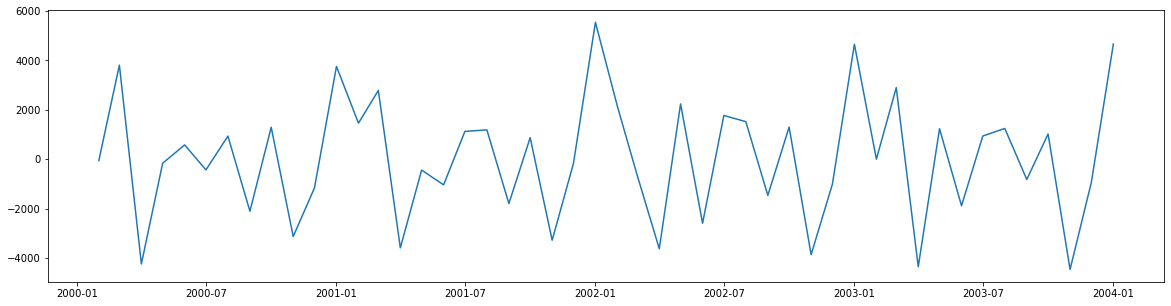

In [11]:
ts_diff = ts - ts.shift()
plt.plot(ts_diff)

In [12]:
ts_diff.dropna(inplace=True)

In [13]:
adafuller_test(ts_diff, 0.05)

ADF Statistic: -8.052801250811912

p-value: 1.7239228907576701e-12

Critial Values: 1%, -3.6209175221605827
Critial Values: 5%, -2.9435394610388332
Critial Values: 10%, -2.6104002410518627

For Significance level (0.05), there is Strong evidence against H0 , Reject H0, Time Series is Stationary


## ACF

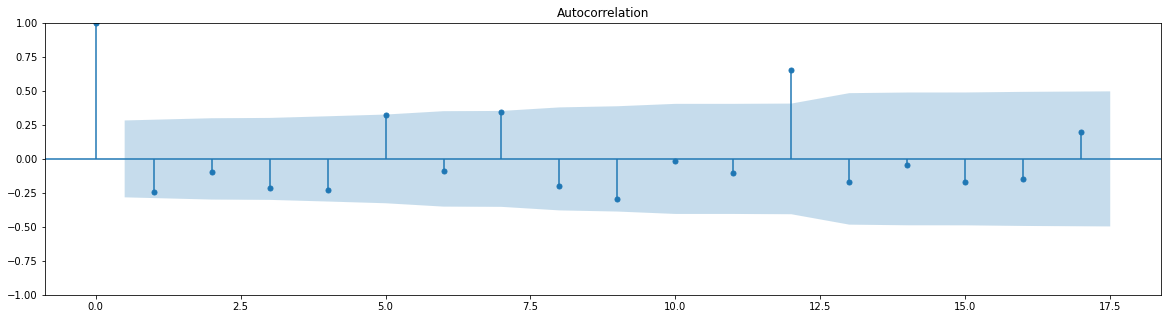

In [14]:
plot_acf(ts_diff)
plt.show()

## PACF

C:\ProgramData\Anaconda3\envs\time_series\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


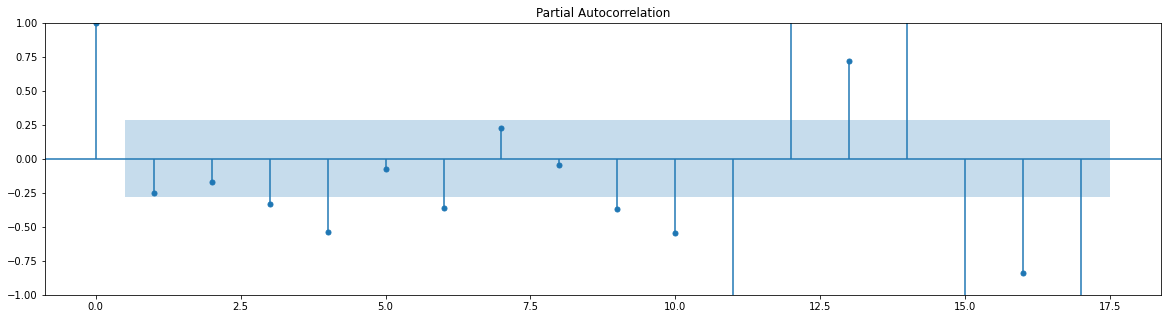

In [15]:
plot_pacf(ts_diff)
plt.show()

In [16]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = ts_diff[:train_end]
test_data = ts_diff[train_end + timedelta(days=1):test_end]

## ARMA Model

In [17]:
# define model
model = ARIMA(train_data, order=(4,0,1))

In [18]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.22487425804138184


In [19]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -376.598
Date:                Tue, 30 Nov 2021   AIC                            767.195
Time:                        17:12:54   BIC                            779.359
Sample:                    02-01-2000   HQIC                           771.654
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1795    179.935      0.134      0.893    -328.487     376.846
ar.L1         -0.8659      0.222     -3.896      0.000      -1.302      -0.430
ar.L2         -0.4234      0.246     -1.724      0.0

In [20]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [21]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

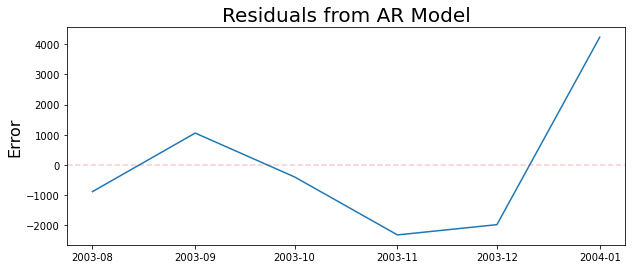

In [22]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

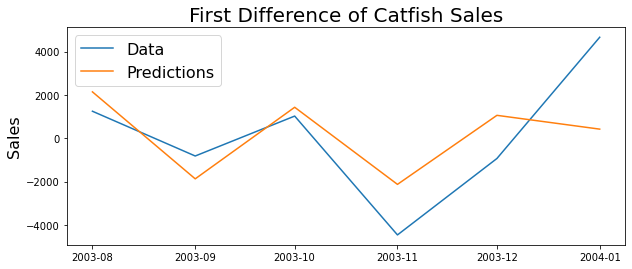

In [23]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)


In [24]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.9941


In [25]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2214.6996900669665


## ARIMA

In [26]:
# define model
model = ARIMA(train_data, order=(4,1,1))

In [27]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.23956561088562012


C:\ProgramData\Anaconda3\envs\time_series\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -370.889
Date:                Tue, 30 Nov 2021   AIC                            753.777
Time:                        17:12:55   BIC                            764.059
Sample:                    02-01-2000   HQIC                           757.521
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5043      0.136     -3.697      0.000      -0.772      -0.237
ar.L2         -0.3073      0.157     -1.962      0.050      -0.614      -0.000
ar.L3         -0.4694      0.216     -2.171      0.0

In [29]:

#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [30]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

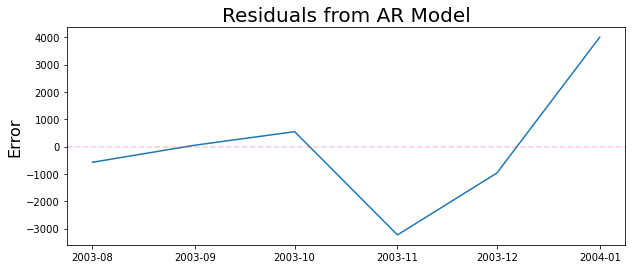

In [31]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

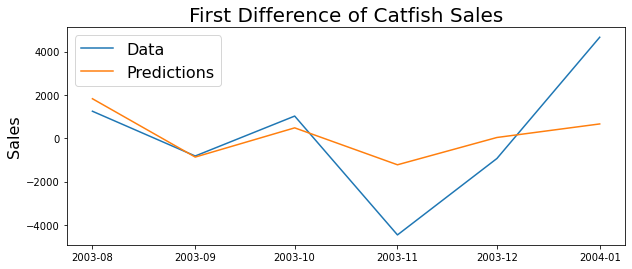

In [32]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [33]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.6127


In [34]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2160.956396143443


## SARIMA

In [35]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [36]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

C:\ProgramData\Anaconda3\envs\time_series\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Model Fitting Time: 0.23926734924316406


In [37]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   42
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -382.527
Date:                              Tue, 30 Nov 2021   AIC                            771.054
Time:                                      17:12:56   BIC                            776.195
Sample:                                  02-01-2000   HQIC                           772.926
                                       - 07-01-2003                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9999      0.001   1158.181      0.000       0.998       1.002
ma.S.L12      -0.95

In [38]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

In [39]:
test_data

date
2003-08-01    1245.0
2003-09-01    -819.0
2003-10-01    1022.0
2003-11-01   -4459.0
2003-12-01    -934.0
2004-01-01    4658.0
Name: Total, dtype: float64

In [40]:
predictions

date
2003-08-01    1315.946925
2003-09-01   -1570.440709
2003-10-01    1258.995656
2003-11-01   -3142.949220
2003-12-01    -602.845866
2004-01-01    4618.470676
Name: predicted_mean, dtype: float64

Text(0, 0.5, 'Error')

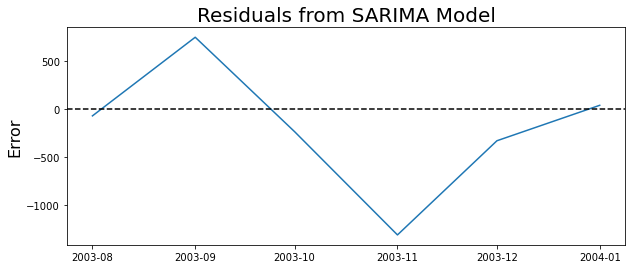

In [41]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [42]:
predictions

date
2003-08-01    1315.946925
2003-09-01   -1570.440709
2003-10-01    1258.995656
2003-11-01   -3142.949220
2003-12-01    -602.845866
2004-01-01    4618.470676
Name: predicted_mean, dtype: float64

Text(0, 0.5, 'Sales')

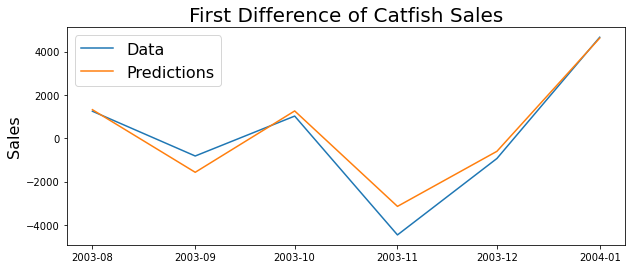

In [43]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [44]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.3108


In [45]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 641.492898050758
